#### Importing necessary modules

In [2]:
import math
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

#### Importing csv files and reading the data

In [3]:
true_odo = genfromtxt('true_odometry.csv', delimiter=',')
sen_odo = genfromtxt('sensor_odom.csv',delimiter=',')

#### Splitting the data into individual arrays

In [ ]:
sen_pos_x, sen_pos_y = sen_odo[1:,1], sen_odo[1:,2]
sen_pos_theta = sen_odo[1:,3]

true_x, true_y, true_theta = true_odo[1:,1], true_odo[1:,2], true_odo[1:,3]
v, w = true_odo[1:,4], true_odo[1:,5]
time = sen_odo[1:,0]

In [3]:
# Observation that we are making - x and y position
z = np.c_[sen_pos_x, sen_pos_y]

#### Defining various variables and matrices that we will use in the Filter

In [4]:
# Transition Matrix
F_t = np.array([  [1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]  ])

# Process Covariance
Q_t = 0.0044 * np.identity(3)

# Measurement Covariance
R_t = np.array([    [0.22, 0],
                    [0, 0.22]   ])

# Measurement Matrix
H_t = np.array([    [1, 0, 0],
                    [0, 1, 0]   ])

# Find lambda for any of the weights
gamma = (0.44)**2
beta = 2

# Defining alpha (weight) values for mean - this step is specific to UKF

alpha_0 = 1/2

alpha_1 = 1/12
alpha_2 = 1/12
alpha_3 = 1/12
alpha_4 = 1/12
alpha_5 = 1/12
alpha_6 = 1/12

cov_alpha_0 = alpha_0 + (1 - gamma + beta)

#### Defining Two Functions that will be used in the main loop

In [5]:
# Computing the Cholesky Decomposition
def decompose(P):

    L  = np.linalg.cholesky(P)

    L_1 = np.array([    [ L[0,0] ],
                        [ L[1,0] ],
                        [ L[2,0] ]   ])

    L_2 = np.array([    [ L[0,1] ],
                        [ L[1,1] ],
                        [ L[2,1] ]   ])

    L_3 = np.array([    [ L[0,2] ],
                        [ L[1,2] ],
                        [ L[2,2] ]   ])

    return L_1, L_2, L_3

In [6]:
def sigma_points(mean,L_1,L_2,L_3):
    # Calculating Sigma Points
    sig_0 = mean

    sig_1 = mean + math.sqrt(3) * L_1
    sig_2 = mean + math.sqrt(3) * L_2
    sig_3 = mean + math.sqrt(3) * L_3

    sig_4 = mean - math.sqrt(3) * L_1
    sig_5 = mean - math.sqrt(3) * L_2
    sig_6 = mean - math.sqrt(3) * L_3

    return sig_0, sig_1, sig_2, sig_3, sig_4, sig_5, sig_6

#### Initial Mean and Cov

In [7]:
# Mean 
mean = np.array([       [sen_pos_x[0]],
                        [sen_pos_y[0]],
                        [sen_pos_theta[0]]      ])

# Cov             
P = np.array([    [0.44, 0, 0],
                  [0, 0.44, 0], 
                  [0, 0, 0.44]   ])

#### Defining empty lists which will be used for plotting purposes later

In [8]:
kal_x, kal_y, kal_theta = [], [], []

### Main Kalman Loop

In [9]:
for i in range(2113):
    
    if i > 0:
        dt = time[i] - time[i-1]
    else:
        dt = 0

    # Prediction Step

    L_1, L_2, L_3 = decompose(P)

    sig_0, sig_1, sig_2, sig_3, sig_4, sig_5, sig_6 = sigma_points(mean,L_1,L_2,L_3)


    # Input Transition Matrix - B
    B_t = np.array([    [dt * (math.cos(sen_pos_theta[i])), 0],
                        [dt * (math.sin(sen_pos_theta[i])), 0],
                        [0, dt]                                    ])
    # Input to the system - v and w ( velocity and turning rate )
    U_t = np.array([    [v[i]],
                        [w[i]]     ])

    # Calculating Projected sigma points through Non-linear Motion Model

    p_sig_0 = F_t.dot(sig_0) + B_t.dot(U_t)

    p_sig_1 = F_t.dot(sig_1) + B_t.dot(U_t)
    p_sig_2 = F_t.dot(sig_2) + B_t.dot(U_t)
    p_sig_3 = F_t.dot(sig_3) + B_t.dot(U_t)

    p_sig_4 = F_t.dot(sig_4) + B_t.dot(U_t)
    p_sig_5 = F_t.dot(sig_5) + B_t.dot(U_t)
    p_sig_6 = F_t.dot(sig_6) + B_t.dot(U_t)


    # Calculating Prediction Mean : Summation of (alphs * p_sig_points)
    predict_mean = (alpha_0*p_sig_0) + (alpha_1*p_sig_1) + (alpha_2*p_sig_2) + (alpha_3*p_sig_3) + (alpha_4*p_sig_4) + (alpha_5*p_sig_5) + (alpha_6*p_sig_6)

    # Calculating Prediction Cov : 
    cov_0 = cov_alpha_0 * ( (p_sig_0 - predict_mean).dot((p_sig_0 - predict_mean).T) ) 

    cov_1 = alpha_1 * ( (p_sig_1 - predict_mean).dot((p_sig_1 - predict_mean).T) )
    cov_2 = alpha_2 * ( (p_sig_2 - predict_mean).dot((p_sig_2 - predict_mean).T) ) 
    cov_3 = alpha_3 * ( (p_sig_3 - predict_mean).dot((p_sig_3 - predict_mean).T) ) 

    cov_4 = alpha_4 * ( (p_sig_4 - predict_mean).dot((p_sig_4 - predict_mean).T) ) 
    cov_5 = alpha_5 * ( (p_sig_5 - predict_mean).dot((p_sig_5 - predict_mean).T) ) 
    cov_6 = alpha_6 * ( (p_sig_6 - predict_mean).dot((p_sig_6 - predict_mean).T) ) 


    predict_cov = cov_0 + cov_1 + cov_2 + cov_3 + cov_4 + cov_5 + cov_6 + Q_t


    # Update Step
    L_1, L_2, L_3 = decompose(predict_cov)

    sig_0, sig_1, sig_2, sig_3, sig_4, sig_5, sig_6 = sigma_points(predict_mean,L_1,L_2,L_3)
    
    # Calculating Projected sigma points through Measurement Model

    m_sig_0 = H_t.dot(sig_0) 

    m_sig_1 = H_t.dot(sig_1) 
    m_sig_2 = H_t.dot(sig_2) 
    m_sig_3 = H_t.dot(sig_3) 

    m_sig_4 = H_t.dot(sig_4) 
    m_sig_5 = H_t.dot(sig_5) 
    m_sig_6 = H_t.dot(sig_6) 

    # Calculating Measurement Mean : Summation of (alphs * p_sig_points)
    measure_mean_y = (alpha_0*m_sig_0) + (alpha_1*m_sig_1) + (alpha_2*m_sig_2) + (alpha_3*m_sig_3) + (alpha_4*m_sig_4) + (alpha_5*m_sig_5) + (alpha_6*m_sig_6)
    
    # Calculating Measurement Cov :

    m_cov_0 = cov_alpha_0 * ( (m_sig_0 - measure_mean_y).dot((m_sig_0 - measure_mean_y).T) )

    m_cov_1 = alpha_1 * ( (m_sig_1 - measure_mean_y).dot((m_sig_1 - measure_mean_y).T) ) 
    m_cov_2 = alpha_2 * ( (m_sig_2 - measure_mean_y).dot((m_sig_2 - measure_mean_y).T) ) 
    m_cov_3 = alpha_3 * ( (m_sig_3 - measure_mean_y).dot((m_sig_3 - measure_mean_y).T) ) 

    m_cov_4 = alpha_4 * ( (m_sig_4 - measure_mean_y).dot((m_sig_4 - measure_mean_y).T) ) 
    m_cov_5 = alpha_5 * ( (m_sig_5 - measure_mean_y).dot((m_sig_5 - measure_mean_y).T) ) 
    m_cov_6 = alpha_6 * ( (m_sig_6 - measure_mean_y).dot((m_sig_6 - measure_mean_y).T) ) 

    predict_cov_y = (m_cov_0 + m_cov_1 + m_cov_2 + m_cov_3 + m_cov_4 + m_cov_5 + m_cov_6) + R_t
    S = np.linalg.inv(predict_cov_y)


    # Calculating Kalman Gain
    cov_xy_0 = cov_alpha_0 * ( (sig_0 - predict_mean).dot((m_sig_0 - measure_mean_y).T) )

    cov_xy_1 = alpha_1 * ( (sig_1 - predict_mean).dot((m_sig_1 - measure_mean_y).T) )
    cov_xy_2 = alpha_2 * ( (sig_2 - predict_mean).dot((m_sig_2 - measure_mean_y).T) )
    cov_xy_3 = alpha_3 * ( (sig_3 - predict_mean).dot((m_sig_3 - measure_mean_y).T) )

    cov_xy_4 = alpha_4 * ( (sig_4 - predict_mean).dot((m_sig_4 - measure_mean_y).T) )
    cov_xy_5 = alpha_5 * ( (sig_5 - predict_mean).dot((m_sig_5 - measure_mean_y).T) )
    cov_xy_6 = alpha_6 * ( (sig_6 - predict_mean).dot((m_sig_6 - measure_mean_y).T) )

    cov_xy = ( cov_xy_0 + cov_xy_1 + cov_xy_2 + cov_xy_3 + cov_xy_4 + cov_xy_5 + cov_xy_6 )

    K = cov_xy.dot(S)


    # Reshaping the measurement data
    Z_t = z[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)

    # Corrected Mean and Cov

    mean = predict_mean + K.dot(Z_t - measure_mean_y)

    P = predict_cov - K.dot(predict_cov_y).dot(K.T)

    kal_x.append(mean[0])
    kal_y.append(mean[1])
    kal_theta.append(mean[2])

In [12]:
print('\n')
print('*'*30)
print('\n',"Final Filter State Matrix : \n", mean,'\n')



******************************

 Final Filter State Matrix : 
 [[-1.90937007]
 [-0.26245011]
 [ 6.23899338]] 



In [13]:
# For Plotting Purposes
kal_x = np.concatenate(kal_x).ravel()
kal_y = np.concatenate(kal_y).ravel()
kal_theta = np.concatenate(kal_theta).ravel()

#### Plots

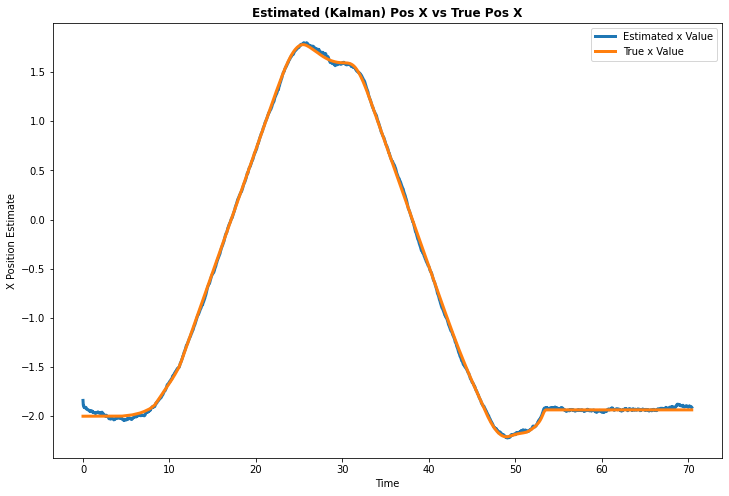

In [14]:
plt.figure(1, figsize=(12,8))
plt.title('Estimated (Kalman) Pos X vs True Pos X', fontweight='bold')
plt.xlabel('Time') 
plt.ylabel('X Position Estimate')  
plt.plot(time,kal_x,'-', linewidth=3,label='Estimated x Value')
plt.plot(time,true_x, linewidth=3,label='True x Value')
plt.legend(loc='best')

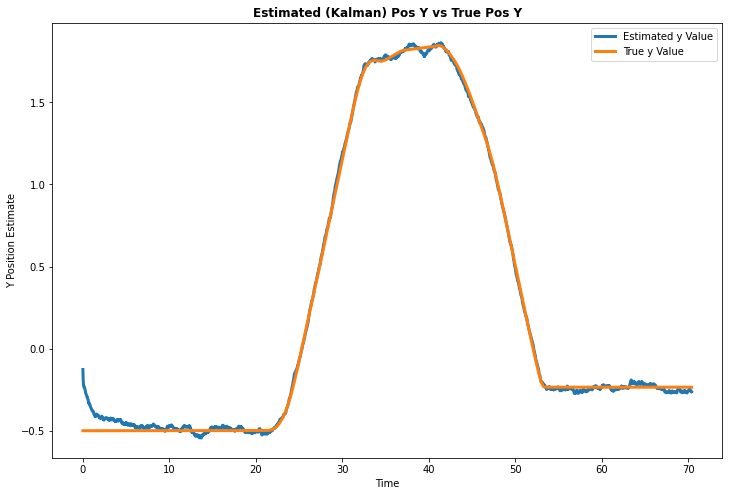

In [16]:
plt.figure(2, figsize=(12,8))
plt.title('Estimated (Kalman) Pos Y vs True Pos Y', fontweight='bold')
plt.xlabel('Time') 
plt.ylabel('Y Position Estimate')   
plt.plot(time,kal_y,'-', linewidth=3,label='Estimated y Value')

plt.plot(time,true_y, linewidth=3, label='True y Value')
plt.legend(loc='best')

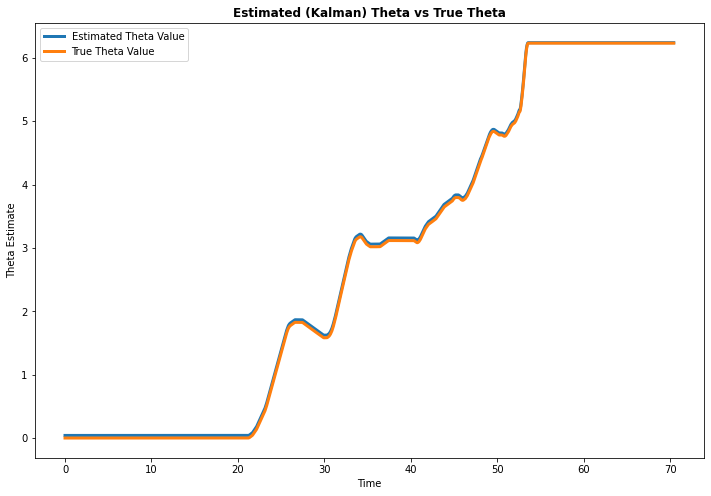

In [17]:
plt.figure(3, figsize=(12,8))
plt.title('Estimated (Kalman) Theta vs True Theta', fontweight='bold')
plt.xlabel('Time') 
plt.ylabel('Theta Estimate')   
plt.plot(time,kal_theta,'-', linewidth=3,label='Estimated Theta Value')
plt.plot(time,true_theta, linewidth=3,label='True Theta Value')
plt.legend(loc='best')

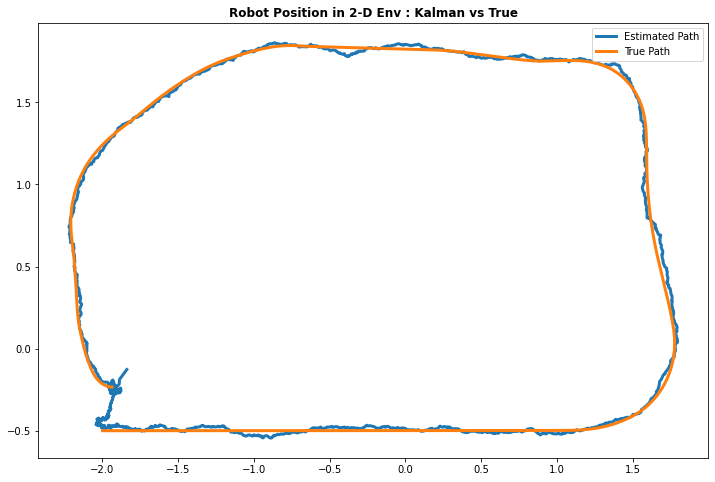

In [18]:
plt.figure(4, figsize=(12,8))
plt.title('Robot Position in 2-D Env : Kalman vs True', fontweight='bold')
plt.plot(kal_x,kal_y,'-', linewidth=3,label='Estimated Path')
plt.plot(true_x,true_y, linewidth=3, label='True Path')
plt.legend(loc='best')